In [ ]:
from pathlib import Path
import numpy as np
from scipy.sparse import coo_matrix
import contextlib
import os
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import networkx as nx


# DSB Class

In [ ]:
class DSB:
    r"""
    Consolidated Discrete Simulated Bifurcation (DSB) algorithm.
    
    
    Args:
        J (Union[numpy.array, csr_matrix]): The coupling matrix with shape :math:`(N x N)`.
        h (numpy.array): The external field with shape :math:`(N, )`.
        x (numpy.array): The initialized spin value with shape :math:`(N x batch_size)`. Default: ``None``.
        n_iter (int): The number of iterations. Default: ``1000``.
        batch_size (int): The number of sampling. Default: ``1``.
        dt (float): The step size. Default: ``1``.
        xi (float): positive constant with the dimension of frequency. Default: ``None``.
    """

    def __init__(
        self,
        J,
        h=None,
        x=None,
        n_iter=1000,
        batch_size=1,
        dt=1,
        xi=None,
    ):
        """Construct DSB algorithm."""
        # Convert coupling matrix J to compressed sparse row format for efficient operations
        self.J = csr_matrix(J)
        
        # Handle external field h
        # If h is provided as a 1D array, reshape it to a column vector
        if h is not None and len(h.shape) < 2:
            h = h[:, np.newaxis]
        self.h = h
        
        # Store initial spin configuration (if provided)
        self.x = x
        
        # Extract the number of spins from the dimension of the coupling matrix
        self.N = self.J.shape[0]
        
        # Store the number of iterations for the simulation
        self.n_iter = n_iter
        
        # Store the batch size (number of parallel simulations)
        self.batch_size = batch_size
        
        # Set Simulated Bifurcation (SB) parameters
        # delta is a constant for the dynamics
        self.delta = 1
        
        # dt is the time step for numerical integration
        self.dt = dt
        
        # Create pumping amplitude parameter that increases linearly from 0 to 1
        # This gradually reduces damping over the course of the simulation
        self.p = np.linspace(0, 1, self.n_iter)
        
        # Handle xi parameter (controls the strength of spin interactions)
        self.xi = xi
        
        # If xi is not provided, calculate it based on the coupling matrix
        # This auto-tuning helps ensure numerical stability
        if self.xi is None:
            # The formula is designed to scale xi inversely with the coupling strength
            # to maintain stability of the simulation
            self.xi = 0.5 * np.sqrt(self.N - 1) / np.sqrt(csr_matrix.power(self.J, 2).sum())
            
        # Initialize spin values (x) and momentum (y) vectors
        self.initialize()

    def initialize(self):
        """Initialize spin values and momentum."""
        # Handle the initialization of spin values (x)
        if self.x is None:
            # If no initial spin configuration was provided in the constructor,
            # create a random initial configuration
            # The values are sampled from a uniform distribution in [-0.01, 0.01]
            # This small random initialization helps break symmetry and allows the
            # system to evolve toward different solutions in different runs
            self.x = 0.02 * (np.random.rand(self.N, self.batch_size) - 0.5)
        elif self.x.shape[0] != self.N:
            # Validate that the provided spin configuration has the correct dimensions
            # If not, raise an informative error message
            # This ensures the spin vector dimensions match the system size defined by J
            raise ValueError(f"The size of x {self.x.shape[0]} is not equal to the number of spins {self.N}")
            
        # Initialize the momentum vector (y)
        # Like the spin values, momentum is initialized to small random values
        # in the range [-0.01, 0.01]
        # The momentum represents the rate of change of the spin values
        # and is a key component of the symplectic integration scheme
        self.y = 0.02 * (np.random.rand(self.N, self.batch_size) - 0.5)

    def calc_cut(self, x=None):
        r"""
        Calculate cut value.

        Args:
            x (numpy.array): The spin value with shape :math:`(N x batch_size)`.
                If ``None``, the initial spin will be used. Default: ``None``.
        """
        # Determine which spin configuration to use for the calculation
        # If x is not provided, use the current state of the system (self.x)
        if x is None:
            # Convert continuous spin values to discrete {-1, +1} values using np.sign()
            sign = np.sign(self.x)
        else:
            # If x is provided, use it instead but still convert to discrete values
            sign = np.sign(x)

        # Calculate the cut value (objective function) for the Ising model
        # The formula computes the energy of the system:
        # 0.25 * sum_ij(J_ij * s_i * s_j) - 0.25 * sum_ij(J_ij)
        # Where:
        # - The first term is the energy contribution from all spin interactions
        # - The second term is a constant offset based on the sum of all coupling values
        #
        # Step by step:
        # 1. self.J.dot(sign) computes the matrix-vector product between J and the signs
        # 2. Multiplying by sign again gives the quadratic form sign^T * J * sign
        # 3. sum(axis=0) sums over all spins to get batch-wise results
        # 4. Subtracting J.sum() accounts for the constant offset
        # 5. The 0.25 scaling factor normalizes the result
        #
        # The result is a measure of how well the current spin configuration
        # minimizes the energy of the Ising model (lower is better)
        return 0.25 * np.sum(self.J.dot(sign) * sign, axis=0) - 0.25 * self.J.sum()

    def update(self):
        """Dynamical evolution based on Modified explicit symplectic Euler method."""
        # Loop through all iterations
        for i in range(self.n_iter):
            # Update the momentum (y) vector
            if self.h is None:
                # Case when no external field is present
                # Formula: y += (-damping_term * x + force_term) * time_step
                # Where:
                # - damping_term: (self.delta - self.p[i]) decreases over time as p[i] increases from 0 to 1
                # - force_term: self.xi * self.J.dot(np.sign(self.x)) represents interaction between spins
                self.y += (-(self.delta - self.p[i]) * self.x + self.xi * self.J.dot(np.sign(self.x))) * self.dt
            else:
                # Case when external field is present
                # Same formula as above but with additional external field term (self.h)
                self.y += (
                    -(self.delta - self.p[i]) * self.x + self.xi * (self.J.dot(np.sign(self.x)) + self.h)
                ) * self.dt

            # Update the position (x) vector using the momentum
            # This is the second part of the symplectic Euler integration
            self.x += self.dt * self.y * self.delta

            # Apply constraints to maintain system stability
            # Identify elements where |x| > 1
            cond = np.abs(self.x) > 1
            
            # For those elements:
            # 1. Set x to its sign (either +1 or -1), effectively clamping the values
            self.x = np.where(cond, np.sign(self.x), self.x)
            # 2. Reset the momentum (y) to zero for those elements to "freeze" them
            self.y = np.where(cond, np.zeros_like(self.y), self.y)




In [ ]:
    # def calc_energy(self, x=None):
    #     r"""
    #     Calculate energy.

    #     Args:
    #         x (numpy.array): The spin value with shape :math:`(N x batch_size)`.
    #             If ``None``, the initial spin will be used. Default: ``None``.
    #     """
    #     if x is None:
    #         sign = np.sign(self.x)
    #     else:
    #         sign = np.sign(x)

    #     if self.h is None:
    #         return -0.5 * np.sum(self.J.dot(sign) * sign, axis=0)
    #     return -0.5 * np.sum(self.J.dot(sign) * sign, axis=0, keepdims=True) - self.h.T.dot(sign)

# Testing

Initial spin values:
[[ 4.35204329e-03 -9.51791125e-03 -6.83530340e-03 -5.16344552e-03
   4.02256423e-03]
 [ 3.70337309e-03 -7.85498699e-03  1.74160922e-03  6.01908030e-03
   3.30156441e-05]
 [-7.36825906e-05  7.84808631e-03  6.85639825e-03  4.90729971e-03
   8.43084146e-03]
 [ 2.23425870e-03  1.25524004e-03 -1.98022514e-03  3.55643604e-03
   6.70730895e-03]
 [-3.08405734e-03  6.03508375e-03 -6.37889722e-03  5.41761613e-03
  -3.02370163e-04]]

Initial cut values:
[-5. -4. -5. -3. -3.]

Final spin values:
[[ 1.  1. -1.  1.  1.]
 [ 1.  1. -1.  1.  1.]
 [ 1.  1. -1.  1.  1.]
 [ 1.  1. -1.  1.  1.]
 [ 1.  1. -1.  1.  1.]]

Final cut values:
[0. 0. 0. 0. 0.]

Final spin signs:
[[ 1.  1. -1.  1.  1.]
 [ 1.  1. -1.  1.  1.]
 [ 1.  1. -1.  1.  1.]
 [ 1.  1. -1.  1.  1.]
 [ 1.  1. -1.  1.  1.]]

Final spin signs diagonal:
[ 1.  1. -1.  1.  1.]

Improvement in cut value: [5. 4. 5. 3. 3.]


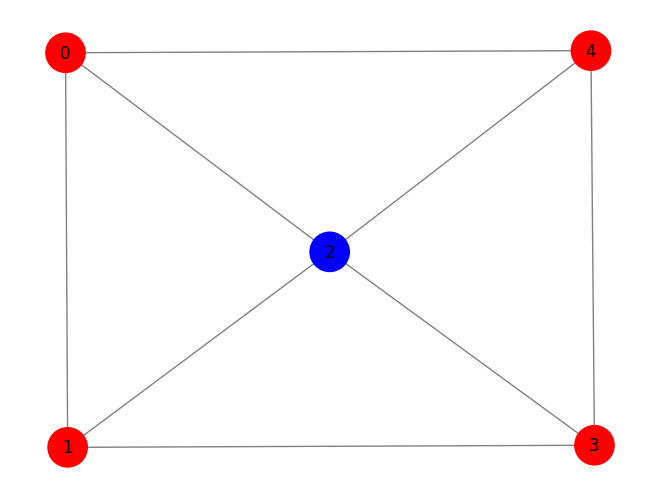

In [3]:
J = np.array([
    [0, 1, 1, 0, 1],  # Node 0 connected to nodes 1, 2, 4
    [1, 0, 1, 1, 0],  # Node 1 connected to nodes 0, 2, 3
    [1, 1, 0, 1, 1],  # Node 2 connected to nodes 0, 1, 3, 4
    [0, 1, 1, 0, 1],  # Node 3 connected to nodes 1, 2, 4
    [1, 0, 1, 1, 0]   # Node 4 connected to nodes 0, 2, 3
])

G = nx.from_numpy_array(J)
# nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800, font_size=12)
# plt.show()

# Initialize the DSB class with our coupling matrix
dsb_instance = DSB(
    J=J,
    batch_size=5,  # Track 3 independent samples
    n_iter=5000     # Number of iterations to run
)

# Store the history of x values and cut values to visualize the evolution
x_history = []
cut_history = []

# Save initial state
x_history.append(dsb_instance.x.copy())
cut_history.append(dsb_instance.calc_cut())

# Run the update function
dsb_instance.update()

# Get final state
final_x = dsb_instance.x
final_cut = dsb_instance.calc_cut()

print("Initial spin values:")
print(x_history[0])
print("\nInitial cut values:")
print(cut_history[0])

print("\nFinal spin values:")
print(final_x)
print("\nFinal cut values:")
print(final_cut)

# Check the final state - the values should converge to near +1 or -1
print("\nFinal spin signs:")
print(np.sign(final_x))
print("\nFinal spin signs diagonal:")
diagonal_elements = np.sign(np.diagonal(final_x))
print(diagonal_elements)


# Calculate improvement in cut value
print(f"\nImprovement in cut value: {final_cut - cut_history[0]}")

node_colors = ['red' if v == 1 else 'blue' for v in diagonal_elements]
nx.draw(G, with_labels=True, node_color=node_colors, edge_color='gray', node_size=800, font_size=12)
plt.show()